In [2]:
from boilerplate import *

In [5]:
dataset = get_data("quac")

Dataset quac downloaded and prepared to /root/.cache/huggingface/datasets/quac/plain_text/1.1.0/4170258e7e72d7c81bd6441b3f3489ea1544f0ff226ce61e22bb00c6e9d01fb6. Subsequent calls will reuse this data.


In [6]:
df = data_to_dataframe(dataset)

In [7]:
training = df[2]

In [8]:
training.head()

,source,target
0,"According to the Indian census of 2001, there ...","[Where is Malayali located?, What other langua..."
1,Malayalam is the language spoken by the Malaya...,"[what language do they speak?, Do they speak a..."
2,After the audition process and several guest v...,"[What do we know about Cove Reber?, How did he..."
3,"The original lineup for Saosin, consisting of ...","[Who formed Saosin?, When was the band founded..."
4,"In 1996, Coolio appeared on the Red Hot Organi...","[How was he associated to Tommy Boy?, Why was ..."


In [9]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [10]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [11]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in training['source'])

In [12]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.5 mins


In [13]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

INFO - 15:13:51: NumExpr defaulting to 2 threads.


(6847, 1)

In [14]:
from gensim.models.phrases import Phrases, Phraser

INFO - 15:13:52: 'pattern' package not found; tag filters are not available for English


In [15]:
sent = [row.split() for row in df_clean['clean']]

In [16]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:13:52: collecting all words and their counts
INFO - 15:13:52: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:13:55: collected 1020124 word types from a corpus of 1476164 words (unigram + bigrams) and 6847 sentences
INFO - 15:13:55: using 1020124 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [17]:
bigram = Phraser(phrases)

INFO - 15:13:55: source_vocab length 1020124
INFO - 15:14:06: Phraser built with 548 phrasegrams


In [18]:
sentences = bigram[sent]

In [19]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

67443

In [20]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['album',
 'band',
 'release',
 'cannotanswer',
 'time',
 'record',
 'year',
 "'",
 'play',
 'song']

In [21]:
import multiprocessing

from gensim.models import Word2Vec

In [22]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [23]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [24]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:14:11: collecting all words and their counts
INFO - 15:14:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:14:15: collected 67443 word types from a corpus of 1429037 raw words and 6847 sentences
INFO - 15:14:15: Loading a fresh vocabulary
INFO - 15:14:15: effective_min_count=20 retains 8820 unique words (13% of original 67443, drops 58623)
INFO - 15:14:15: effective_min_count=20 leaves 1235408 word corpus (86% of original 1429037, drops 193629)
INFO - 15:14:15: deleting the raw counts dictionary of 67443 items
INFO - 15:14:15: sample=6e-05 downsamples 1303 most-common words
INFO - 15:14:15: downsampling leaves estimated 781064 word corpus (63.2% of prior 1235408)
INFO - 15:14:15: estimated required memory for 8820 words and 300 dimensions: 25578000 bytes
INFO - 15:14:15: resetting layer weights


Time to build vocab: 0.11 mins


In [25]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:14:17: training model with 1 workers on 8820 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:14:18: EPOCH 1 - PROGRESS: at 10.78% examples, 80765 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:19: EPOCH 1 - PROGRESS: at 22.26% examples, 82831 words/s, in_qsize 2, out_qsize 0
INFO - 15:14:20: EPOCH 1 - PROGRESS: at 34.41% examples, 84342 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:21: EPOCH 1 - PROGRESS: at 45.70% examples, 84444 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:22: EPOCH 1 - PROGRESS: at 56.67% examples, 84725 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:23: EPOCH 1 - PROGRESS: at 67.78% examples, 84819 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:24: EPOCH 1 - PROGRESS: at 79.09% examples, 85210 words/s, in_qsize 1, out_qsize 0
INFO - 15:14:25: EPOCH 1 - PROGRESS: at 90.35% examples, 85548 words/s, in_qsize 2, out_qsize 0
INFO - 15:14:26: worker thread finished; awaiting finish of 0 more threads
INFO - 15:14:26: EPOCH 

Time to train the model: 4.55 mins


In [26]:
w2v_model.init_sims(replace=True)

INFO - 15:18:50: precomputing L2-norms of word weight vectors


In [27]:
w2v_model.wv.most_similar(positive=["football"])

[('football_team', 0.5286812782287598),
 ('ohio_state', 0.5182080268859863),
 ('professional_football', 0.510517954826355),
 ('monday_night', 0.507183313369751),
 ('varsity', 0.4907870292663574),
 ('football_league', 0.48755940794944763),
 ('canton', 0.47640755772590637),
 ('soccer', 0.47064411640167236),
 ('indoor', 0.4684675931930542),
 ('pele', 0.466777503490448)]

In [30]:
w2v_model.wv.most_similar(positive=["india"])

[('sri_lanka', 0.6226263046264648),
 ('delhi', 0.6059539318084717),
 ('bombay', 0.5406875610351562),
 ('bangladesh', 0.5384056568145752),
 ('mumbai', 0.5364909172058105),
 ('kenya', 0.520317018032074),
 ('lahore', 0.5196903944015503),
 ('pakistan', 0.5196082592010498),
 ('bose', 0.5155715942382812),
 ('punjab', 0.511029839515686)]

In [31]:
w2v_model.wv.most_similar(positive=["internet"])

[('leak', 0.6635940670967102),
 ('retailer', 0.5620056390762329),
 ('viral', 0.5336290597915649),
 ('web', 0.5280978679656982),
 ('circulate', 0.5163200497627258),
 ('streaming', 0.5133022665977478),
 ('digital_download', 0.504462718963623),
 ('youtube', 0.501811146736145),
 ('online', 0.4969925880432129),
 ('amazon', 0.49057918787002563)]

In [32]:
w2v_model.wv.most_similar(positive=["fraud"])

[('acquit', 0.5682245492935181),
 ('cuccinelli', 0.5633305311203003),
 ('ghomeshi', 0.5527079701423645),
 ('prosecute', 0.547006368637085),
 ('corruption', 0.5438084602355957),
 ('plead_guilty', 0.541864275932312),
 ('wakefield', 0.5381290912628174),
 ('adelson', 0.5374290943145752),
 ('prosecution', 0.5320479273796082),
 ('investigator', 0.5269956588745117)]

In [33]:
w2v_model.wv.similarity("goodbye", 'hey')

0.3769367

In [34]:
w2v_model.wv.similarity('football', 'cricket')

0.3664318

In [36]:
w2v_model.wv.similarity('politic', 'football')

0.16643819

In [37]:
w2v_model.wv.doesnt_match(['pele', 'politic', 'football'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'politic'

In [43]:
w2v_model.wv.doesnt_match(["mouse", "computer", "internet"])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'mouse'

In [50]:
w2v_model.wv.doesnt_match(['biology', 'science', 'games'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'games'

In [60]:
w2v_model.wv.most_similar(positive=["greek", "spain"], negative=["egypt"], topn=10)

[('latin', 0.4372386336326599),
 ('fluent', 0.3866032063961029),
 ('etruscans', 0.36936211585998535),
 ('fable', 0.367143839597702),
 ('salvador', 0.36662495136260986),
 ('greece', 0.36617064476013184),
 ('sanchez', 0.3596436381340027),
 ('ancestor', 0.3584829568862915),
 ('sculpture', 0.3531267046928406),
 ('bronze', 0.3415820002555847)]

In [66]:
w2v_model.wv.most_similar(positive=["biology", "bird", "india", "reserve", "sanctuary"], negative=["politic"], topn=10)

[('buddhist', 0.4592025578022003),
 ('battalion', 0.44690725207328796),
 ('underwater', 0.44341516494750977),
 ('guinea', 0.4393549859523773),
 ('delhi', 0.43675750494003296),
 ('mediterranean', 0.43113455176353455),
 ('tu', 0.4150592088699341),
 ('mackinac', 0.40869325399398804),
 ('geography', 0.4080970287322998),
 ('champlain', 0.4080502390861511)]

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [74]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    
    

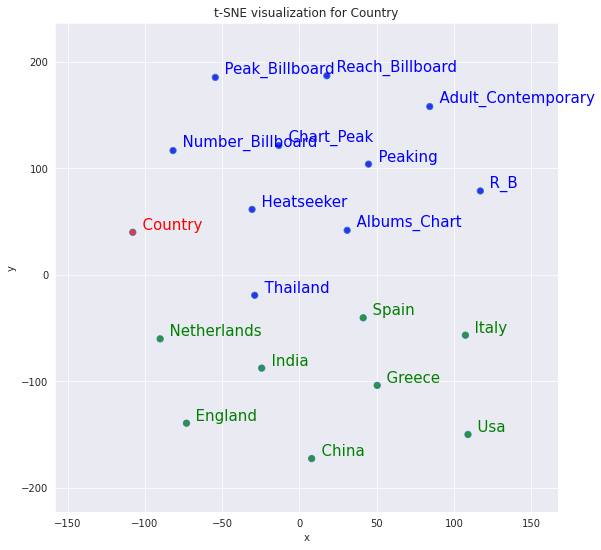

In [75]:
tsnescatterplot(w2v_model, 'country', ['greece', 'netherlands', 'china', 'usa', 'italy', 'england', 'spain', 'india'])

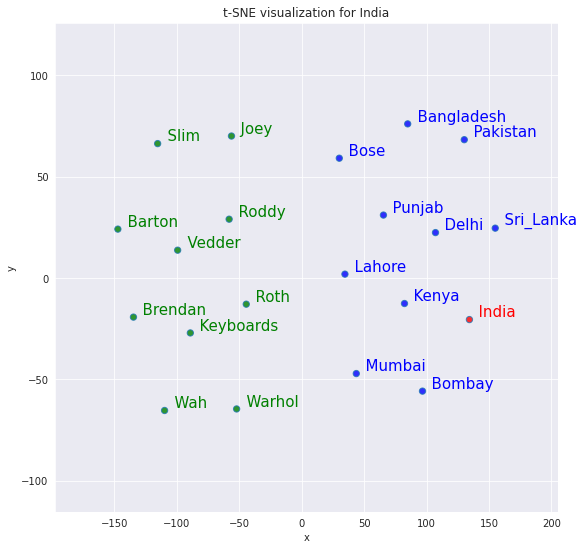

In [76]:
tsnescatterplot(w2v_model, 'india', [i[0] for i in w2v_model.wv.most_similar(negative=["india"])])

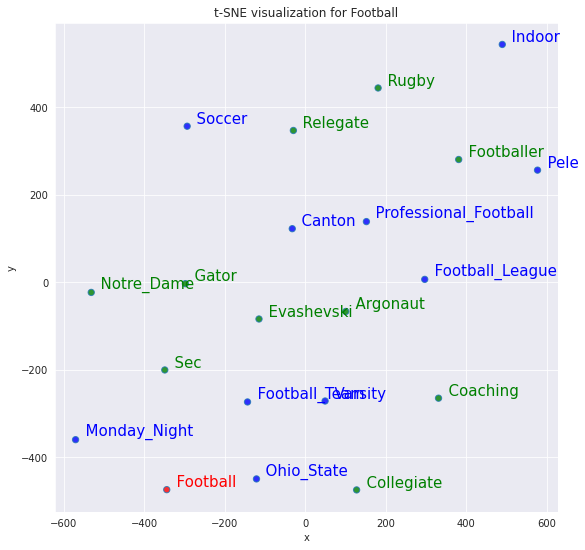

In [77]:
tsnescatterplot(w2v_model, "football", [t[0] for t in w2v_model.wv.most_similar(positive=["football"], topn=20)][10:])